In [ ]:
#Step 1: import the necessary modules

from keras.layers.core import Activation, Dense, Dropout, SpatialDropout1D
from keras.layers.embeddings import Embedding
from keras.layers.recurrent import LSTM
from keras.models import Sequential
from keras.preprocessing import sequence
from sklearn.model_selection import train_test_split
import collections
import matplotlib.pyplot as plt
import nltk
import numpy as np
import os

Using TensorFlow backend.


In [ ]:
# Step 2: Do an exploratory analysis on the data
# a) How many unique words in the corpus?
# b) How many words are there in each sentence?

maxlen = 0
word_freqs = collections.Counter()
num_recs = 0

#open the file (ore than 7000 short sentences) as a binary file
#from UMICH SI650 sentiment classification competition on Kaggle
#DATA_DIR = "/home/one/Desktop/"
#ftrain = open(os.path.join(DATA_DIR, "umich-sentiment-train.txt"), 'rb')

#open the text file as binary
from tkinter import filedialog
from tkinter import *
 
root = Tk()
root.filename =  filedialog.askopenfilename(initialdir = "/",
                                   title = "Select file",
                                   filetypes = (("Text File","*.txt"),("All Files","*.*")))
print (root.filename)
ftrain = open(root.filename, "rb") 
root.destroy()


#for each line (label \t sentence)
for line in ftrain:
    
    #remove leading and trailing white spaces, then convert it to lower case 
    line = line.strip().lower() 
    
    #Remove non-ASCII characters
    line = line.decode("ascii", "ignore")
        
    #extract the label and the sentence from line 
    label, sentence = line.split('\t')
   
    #convert sentence string into a list of tokenizers 
    #period is a separate tokenizer.
    #str.split() attach the last word with the period
    words = nltk.word_tokenize(sentence)
    
    #maxlen represents the length of longest sentence
    if len(words) > maxlen:
        maxlen = len(words)
    
    #build the words histogram (word frequency)
    for word in words:
        word_freqs[word] +=1
    
    #number of samples or sentences
    num_recs += 1
        
ftrain.close()

print("maxlen: " , maxlen)
print("number of unique words = len(word_freqs): ", len(word_freqs))
print("number of samples (or sentences): " , num_recs)

In [3]:
# number of unique words = len(word_freqs) = fixed vocabulary size
# All other words (out of vocabulary OOV) (UNK unknown)
MAX_FEATURES = 2000

# number of words in sentence = fixed seqence length 
#(zero pad shorter sentences, truncate longer sentences)
MAX_SENTENCE_LENGTH = 40

In [4]:
#vocabulary size = 2000 + UNK + PAD
vocab_size = min(MAX_FEATURES, len(word_freqs)) + 2

#lookup table to lookup an index given a word
# dictionary: key(word), value(index)
word2index = {x[0]: i+2 for i, x in 
    enumerate(word_freqs.most_common(MAX_FEATURES))}
word2index["PAD"] = 0
word2index["UNK"] = 1
print(word2index)

#lookup table to lookup a word given an index
# dictionary: key(index), value(word)
index2word = {v:k for k, v in word2index.items()}
print(index2word)

{'i': 2, ',': 3, '.': 4, 'the': 5, 'and': 6, '!': 7, 'harry': 8, 'vinci': 9, 'da': 10, 'brokeback': 11, 'code': 12, 'mountain': 13, 'potter': 14, '...': 15, 'love': 16, 'is': 17, 'a': 18, 'was': 19, 'mission': 20, 'impossible': 21, 'awesome': 22, 'like': 23, 'it': 24, 'to': 25, 'movie': 26, 'that': 27, "'s": 28, 'because': 29, 'sucks': 30, 'hate': 31, 'sucked': 32, 'so': 33, 'as': 34, 'my': 35, '``': 36, 'much': 37, 'of': 38, 'really': 39, 'movies': 40, 'stupid': 41, 'you': 42, 'down': 43, 'but': 44, 'we': 45, 'be': 46, 'with': 47, 'just': 48, 'one': 49, 'know': 50, 'potter..': 51, 'suck': 52, 'out': 53, '3': 54, 'who': 55, '/': 56, 'or': 57, 'am': 58, 'loved': 59, 'want': 60, 'into': 61, 'which': 62, 'right': 63, 'for': 64, 'an': 65, "n't": 66, 'this': 67, 'me': 68, ':': 69, 'are': 70, 'think': 71, 'not': 72, 'how': 73, 'if': 74, 'depressing': 75, 'people': 76, 'his': 77, 'would': 78, 'up': 79, 'reading': 80, 'why': 81, 'series': 82, 'there': 83, 'in': 84, 'only': 85, 'fucking': 86, '

In [5]:
# Step 3: convert input sentences to word index sequences
# and pad them to MAX_SENTENCE_LENGTH words

# empty array of lists, each list contains word indes sequences
X = np.empty((num_recs, ), dtype=list)

#output label 
y = np.zeros((num_recs, ))

i=0

#open the file (ore than 7000 short sentences) as a binary file
#from UMICH SI650 sentiment classification competition on Kaggle
DATA_DIR = "/home/one/Desktop/"
ftrain = open(os.path.join(DATA_DIR, "umich-sentiment-train.txt"), 'rb')

#for each line (label \t sentence)
for line in ftrain:
    
    #remove leading and trailing white spaces, then convert it to lower case 
    line = line.strip().lower() 
    
    #Remove non-ASCII characters
    line = line.decode("ascii", "ignore")
        
    #extract the label and the sentence from line 
    label, sentence = line.split('\t')
   
    #convert sentence string into a list of tokenizers 
    #period is a separate tokenizer.
    #str.split() attach the last word with the period
    words = nltk.word_tokenize(sentence)
    
    # word_index_sequence
    seqs = []
    
    # for each word in the sentence
    for word in words:
        # if the word is already in the lookup table, it has an index 
        if word in word2index:
            # attach its index to the word_index_sequence
            seqs.append(word2index[word])
            
        # if the word is not in the lookup table, attach the index of UNKNOWN
        else:
            seqs.append(word2index["UNK"])
        
        
    X[i] = seqs
    y[i] = int(label)
    i += 1
        
ftrain.close()

# pad each word_index_sequence 
X = sequence.pad_sequences(X, maxlen = MAX_SENTENCE_LENGTH) 
print(X)        
    
    

[[  0   0   0 ...  48  22   4]
 [  0   0   0 ... 340  67   4]
 [  0   0   0 ...  18 324   4]
 ...
 [  0   0   0 ...  11  13   4]
 [  0   0   0 ... 127  26   4]
 [  0   0   0 ...  87  26   4]]


In [6]:
# Step 4, split the training set into 80-20 training set split
Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, test_size=0.2, random_state=42)

In [14]:
EMBEDDING_SIZE = 128
HIDDEN_LAYER_SIZE = 64
BATCH_SIZE = 32
NUM_EPOCHS = 10

# The input tensor shape is (None, MAX_SENTENCE_LENGTH, 1)
# Embedding layer of size EMBEDDING_SIZE
# Embedding layer output tensor shape is (None, MAX_SENTENCE_LENGTH, EMBEDDING_SIZE)
# LSTM with sequence length MAX_SENTENCE_LENGTH, and output layer size HIDDEN_LAYER_SIZE
# LSTM output tensor shape is (None, HIDDEN_LAYER_SIZE, MAX_SENTENCE_LENGTH)

model = Sequential()
model.add(Embedding(vocab_size, EMBEDDING_SIZE, input_length=MAX_SENTENCE_LENGTH))
#model.add(SpatialDropout1D(Dropout(0.2)))
model.add(SpatialDropout1D(0.2))
model.add(LSTM(HIDDEN_LAYER_SIZE, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(1))
model.add(Activation("sigmoid"))

# binary cross-entropy loss function to predict a binary value
# Adam optimizer is a good general purpose optimizer
model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])

In [18]:
# Training step (10 epochs, 32 batch size)
history = model.fit(Xtrain, ytrain, batch_size=BATCH_SIZE, epochs=NUM_EPOCHS, validation_data=(Xtest, ytest))

Train on 5668 samples, validate on 1418 samples
Epoch 1/10
5668/5668 [==============================] - 19s 3ms/step - loss: 0.0036 - acc: 0.9993 - val_loss: 0.0562 - val_acc: 0.9880
Epoch 2/10
5668/5668 [==============================] - 17s 3ms/step - loss: 0.0019 - acc: 0.9995 - val_loss: 0.0528 - val_acc: 0.9880
Epoch 3/10
5668/5668 [==============================] - 18s 3ms/step - loss: 7.3280e-04 - acc: 0.9998 - val_loss: 0.0534 - val_acc: 0.9866
Epoch 4/10
5668/5668 [==============================] - 28s 5ms/step - loss: 9.2049e-04 - acc: 0.9998 - val_loss: 0.0522 - val_acc: 0.9880
Epoch 5/10
5668/5668 [==============================] - 22s 4ms/step - loss: 6.0086e-04 - acc: 0.9998 - val_loss: 0.0589 - val_acc: 0.9873
Epoch 6/10
5668/5668 [==============================] - 20s 3ms/step - loss: 5.6322e-04 - acc: 0.9996 - val_loss: 0.0571 - val_acc: 0.9880
Epoch 7/10
5668/5668 [==============================] - 23s 4ms/step - loss: 7.2813e-04 - acc: 0.9996 - val_loss: 0.0574 - val

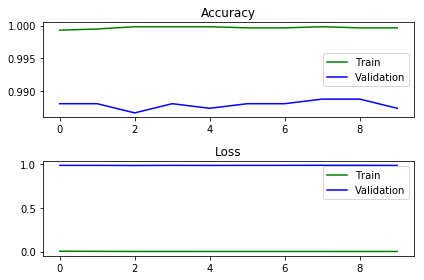

In [19]:
# Plotting the loss and accuracy values over time
plt.subplot(211)
plt.title("Accuracy")
plt.plot(history.history["acc"], color="g", label="Train")
plt.plot(history.history["val_acc"], color="b", label="Validation")
plt.legend(loc="best")

plt.subplot(212)
plt.title("Loss")
plt.plot(history.history["loss"], color="g", label="Train")
plt.plot(history.history["val_acc"], color="b", label="Validation")
plt.legend(loc="best")

plt.tight_layout()
plt.show()

In [20]:
# Testing
score, acc = model.evaluate(Xtest, ytest, batch_size=BATCH_SIZE)
print("Test score: " + str(score) + ", accuracy: " + str(acc))

1418/1418 [==============================] - 1s 823us/step
Test score: 0.07063075199115629, accuracy: 0.9873060648801129


In [45]:
# Show the output of a few random samples from the test set
for i in range(5):
    idx = np.random.randint(len(Xtest))
    xtest = Xtest[idx].reshape(1,40)
    
    ylabel = ytest[idx]
    ypred = model.predict(xtest)[0]
    sent = " ".join([index2word[x] for x in xtest[0].tolist() if x != 0])
    print(str(ypred) + " " + str(ylabel) + " " + str(sent))

[0.00879002] 0.0 my point is , harry potter is evil ...
[0.9999995] 1.0 i liked the first `` mission impossible .
[1.8932224e-05] 0.0 mission impossible iii sucked please do n't go see it , okay ? ...
[0.00160522] 0.0 said `` the da vinci code `` suck..
[9.415697e-06] 0.0 she was just absolutely adorable in am lie , one of my favorite films , and while the da vinci code pretty much sucked , she looked good in it .
